We have selected three stocks Apple, Tesla, Nvidia from Nasdaq to perform our stock prediction analysis. The actual prediction output has been saved in a seperate excel file.

These 3 stocks are huge tech names, who are dominant players in their own products include but not limited to phone/computer, electric cars, specialized chips. While they focued on different products but their products are closely related to an emerging Artificial Intelligent field. Stock data from 2022-01-01 to current date included hourly prices, trading volume etc. are extracted from yahoo finance.

From below graph is a trend line of the closing price for each stock. We notice aapl and nvdasha similar trend line. For Tesla, it rises to peak toward the August and fall back to near 200 USD lately.

In general, they all display a growing trend in their stock prices. Starting from July, the stock prices of AAPL, TSLA, NVDA, have been flatten and slowed down the pace of growing, which is better reflected in the mean average of the price in second graph.


 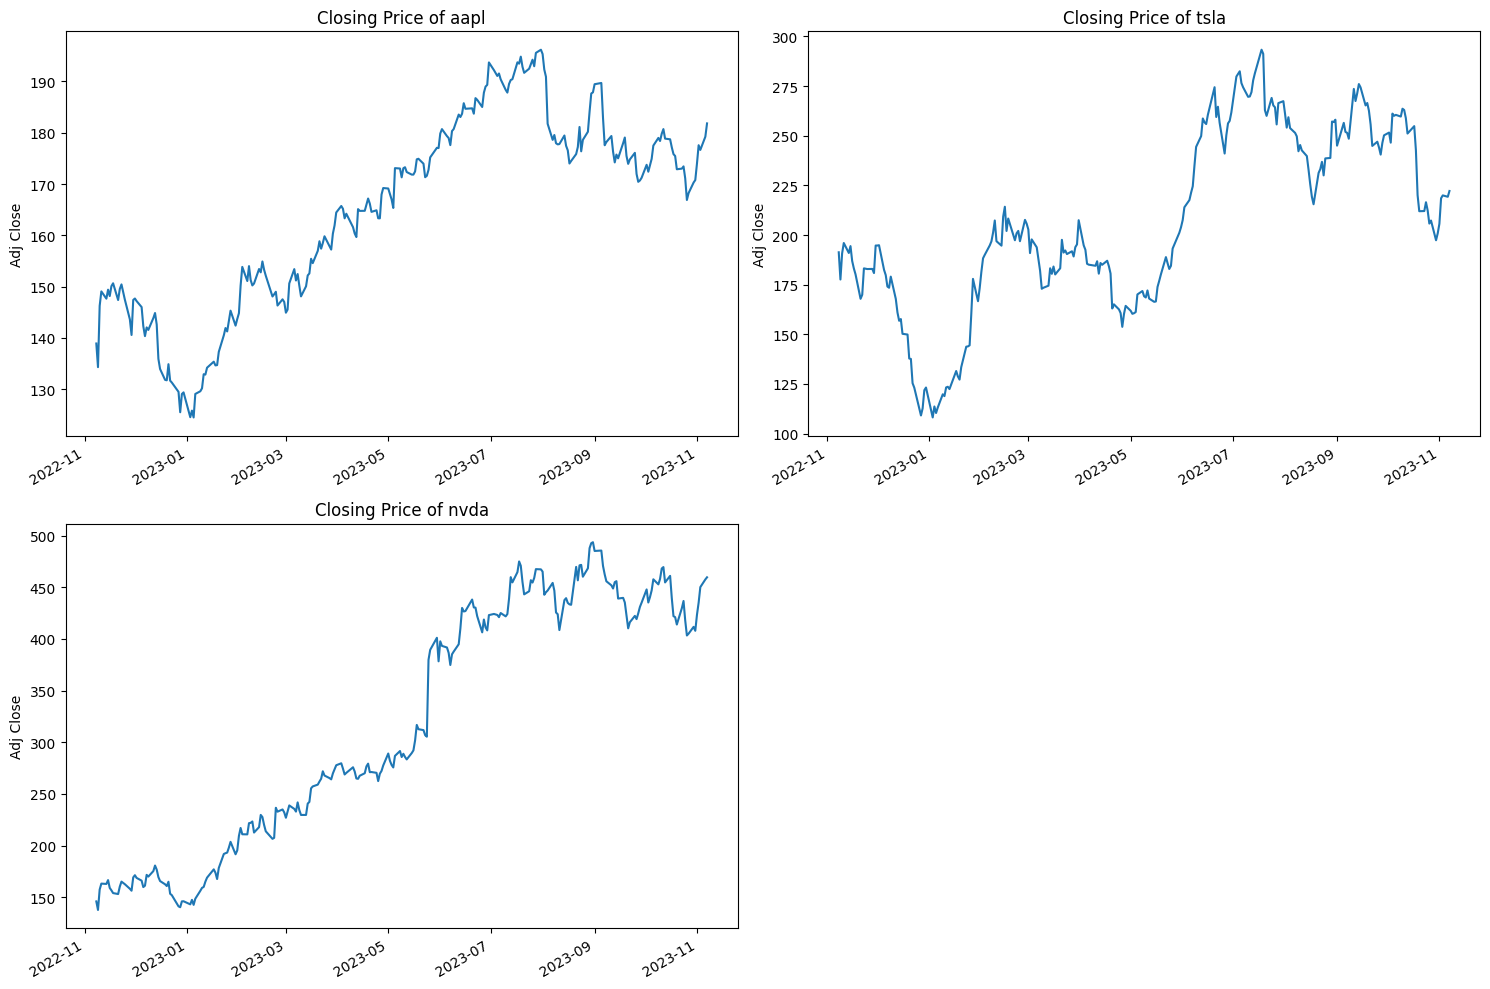
 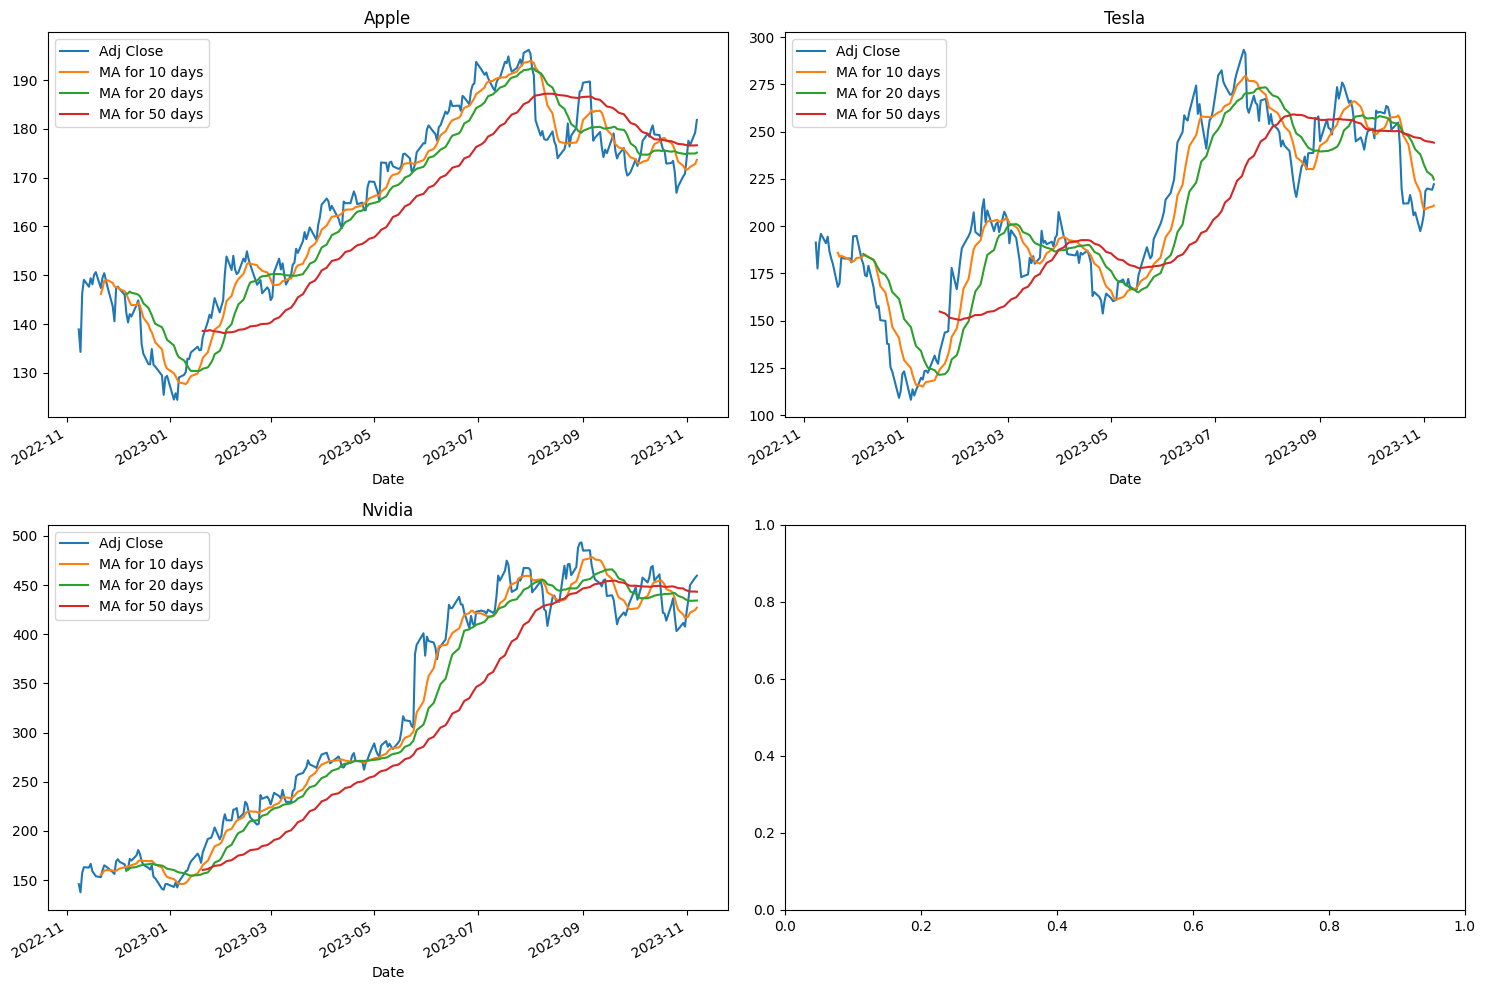

The trading volume rises significantly before/during the fall or burst of the stock prices.

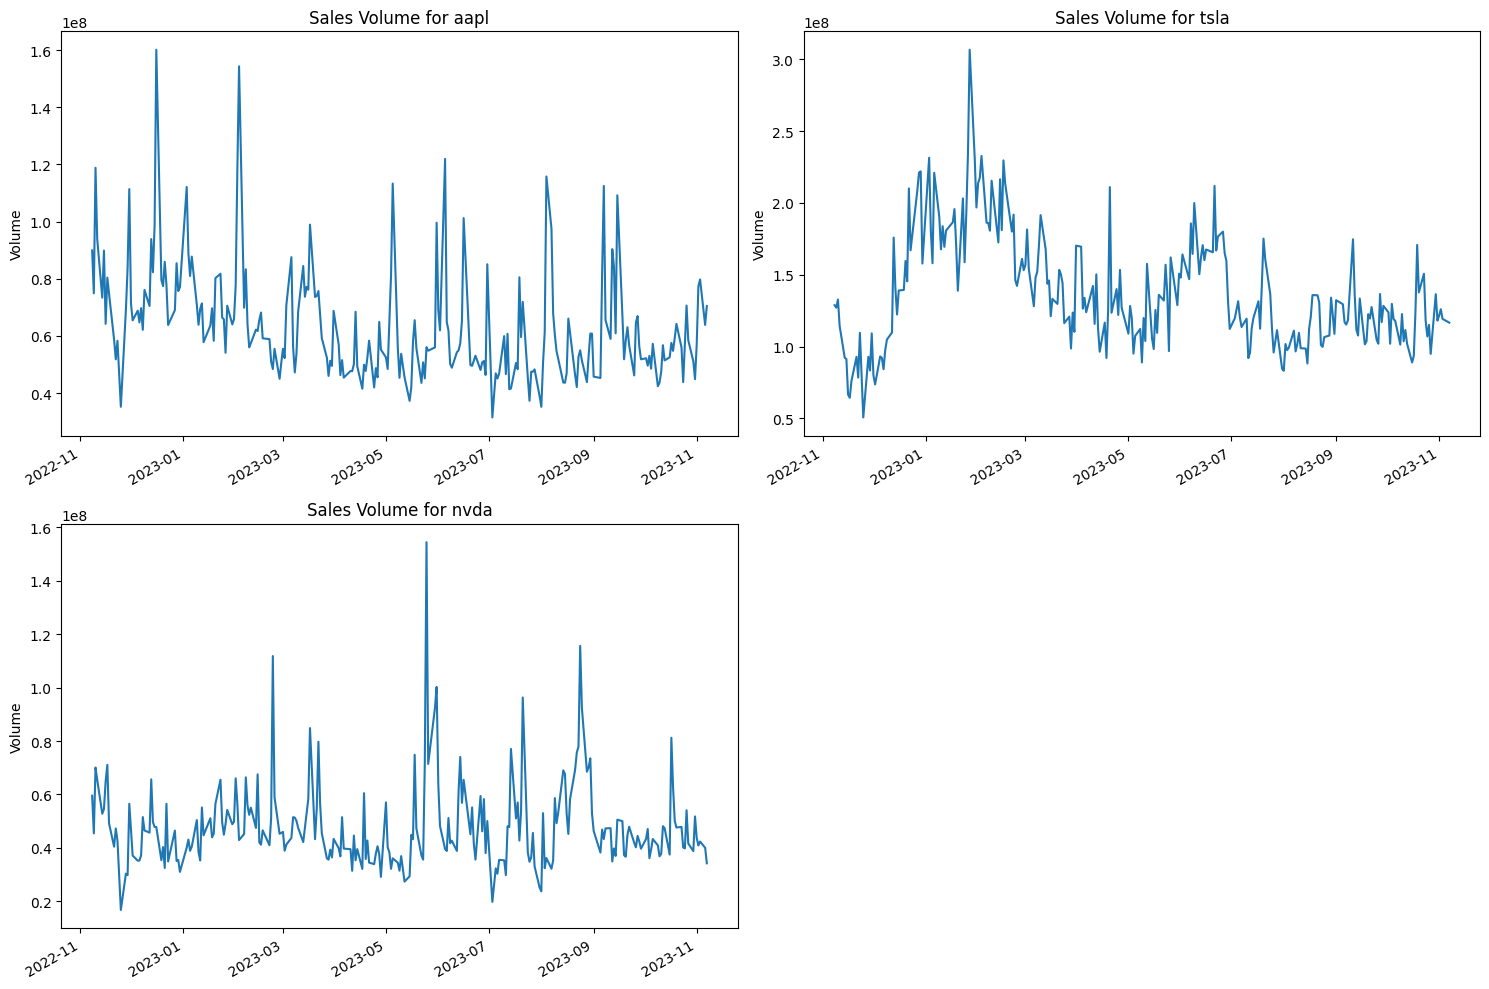

Stock prices dataset is a sequential data consiting of the prices at different time such as daily, hourly, open, close prices. So we would like to use the Long Short-Term Memory(LSTM) method to create a Machine Learning model to forecast stock values. Stock prices exhibit temporal dependencies, where the current price is influenced by past prices and market trends. LSTM networks are capable of capturing these dependencies and making predictions based on historical patterns.

We have used 3,000 hourly prices as the training data to predict the remainder(250+) of the prices as test set. The result is evaluate by the graph and hourly MSE.

AAPL price prediction perform well with LSTM model showing a loss of 7.3461e-04
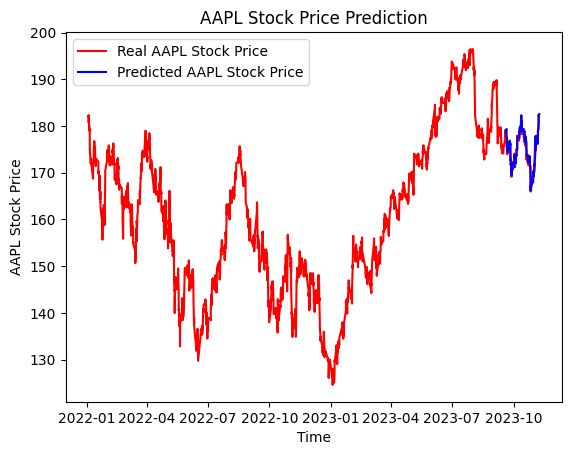

Hourly Loss of the Prediction:
Hour: 2023-11-06 09:30:00, MSE: 4.125914573902264;
Hour: 2023-11-06 10:30:00, MSE: 5.735533848404884;
Hour: 2023-11-06 11:30:00, MSE: 0.9176327942404896;
Hour: 2023-11-06 12:30:00, MSE: 0.2686932778451592;
Hour: 2023-11-06 13:30:00, MSE: 0.0791101458016783;
Hour: 2023-11-06 14:30:00, MSE: 0.09639198170043528;
Hour: 2023-11-06 15:30:00, MSE: 0.0640738105867058.


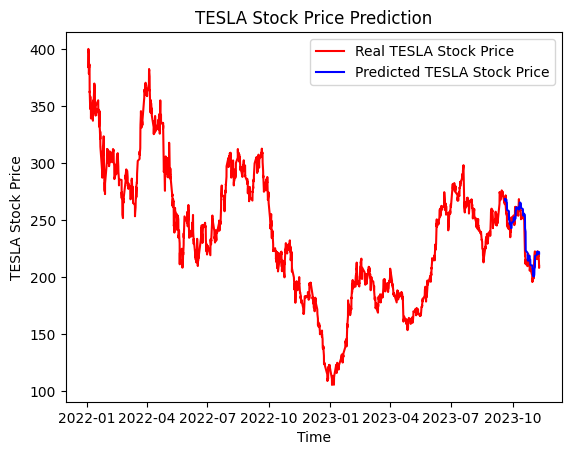

In NVDA prediction, even though I have adjust the parameter of previous LSTM model and extend the timesteps to 150 and showing a small loss of 0.0011. The actualy prediction has still been terrible with a signficant difference between prediction and actual prices. The hourly loss for prediction is also very large. So I decide to apply linear regression model. In the second graph, the linear regression model has performed significantly better than LSTM with a loss of 2.09939441402364. And we randomly select a date to verify if the hourly MSE is small enough.

The hourly MSE for prediction
2023-11-6 Hour: 9:30, MSE: 4.118145327944498;
Hour: 10:30, MSE: 1.175698814551721;
Hour: 11:30, MSE: 0.8292187829539434;
Hour: 12:30, MSE: 0.7127599147279085;
Hour: 13:30, MSE: 0.6770940937448966;
Hour: 14:30, MSE: 0.8633705923496042
Hour: 15:30, MSE: 0.501084892487097

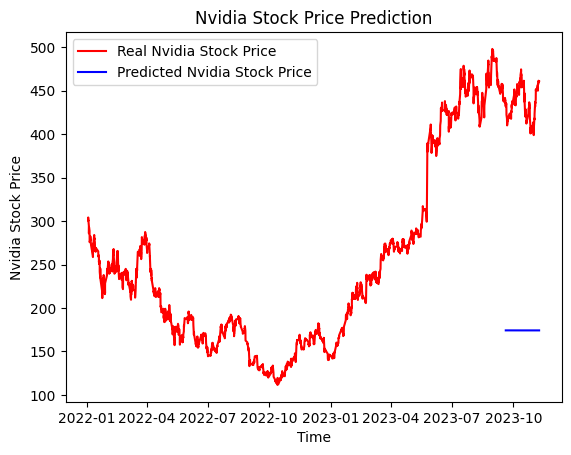

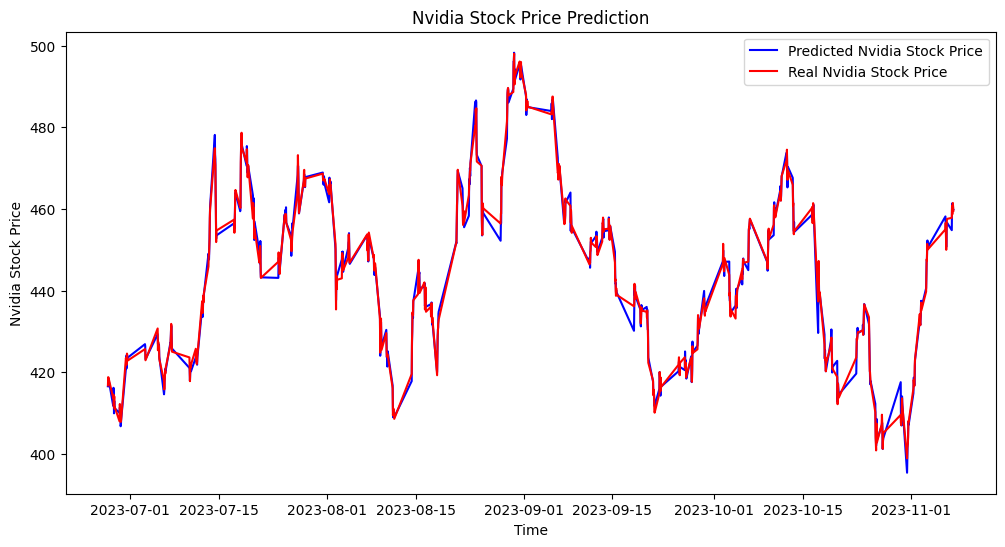

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense, Activation, LSTM, Dropout
from keras import preprocessing
import matplotlib.dates as mdates
from pandas_datareader import data as pdr
from pandas_datareader.data import DataReader
import seaborn as sns

from datetime import datetime




In [13]:
#import stock data from yahoo finance
aapl = yf.Ticker("aapl")
aapl_prices = aapl.history(start="2022-01-01", period = 'max', interval="1h")

tsla = yf.Ticker("tsla")
tsla_prices = tsla.history(start="2022-01-01", period = 'max', interval="1h")

nvda = yf.Ticker("nvda")
nvda_prices = nvda.history(start="2022-01-01", period = 'max', interval="1h")


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


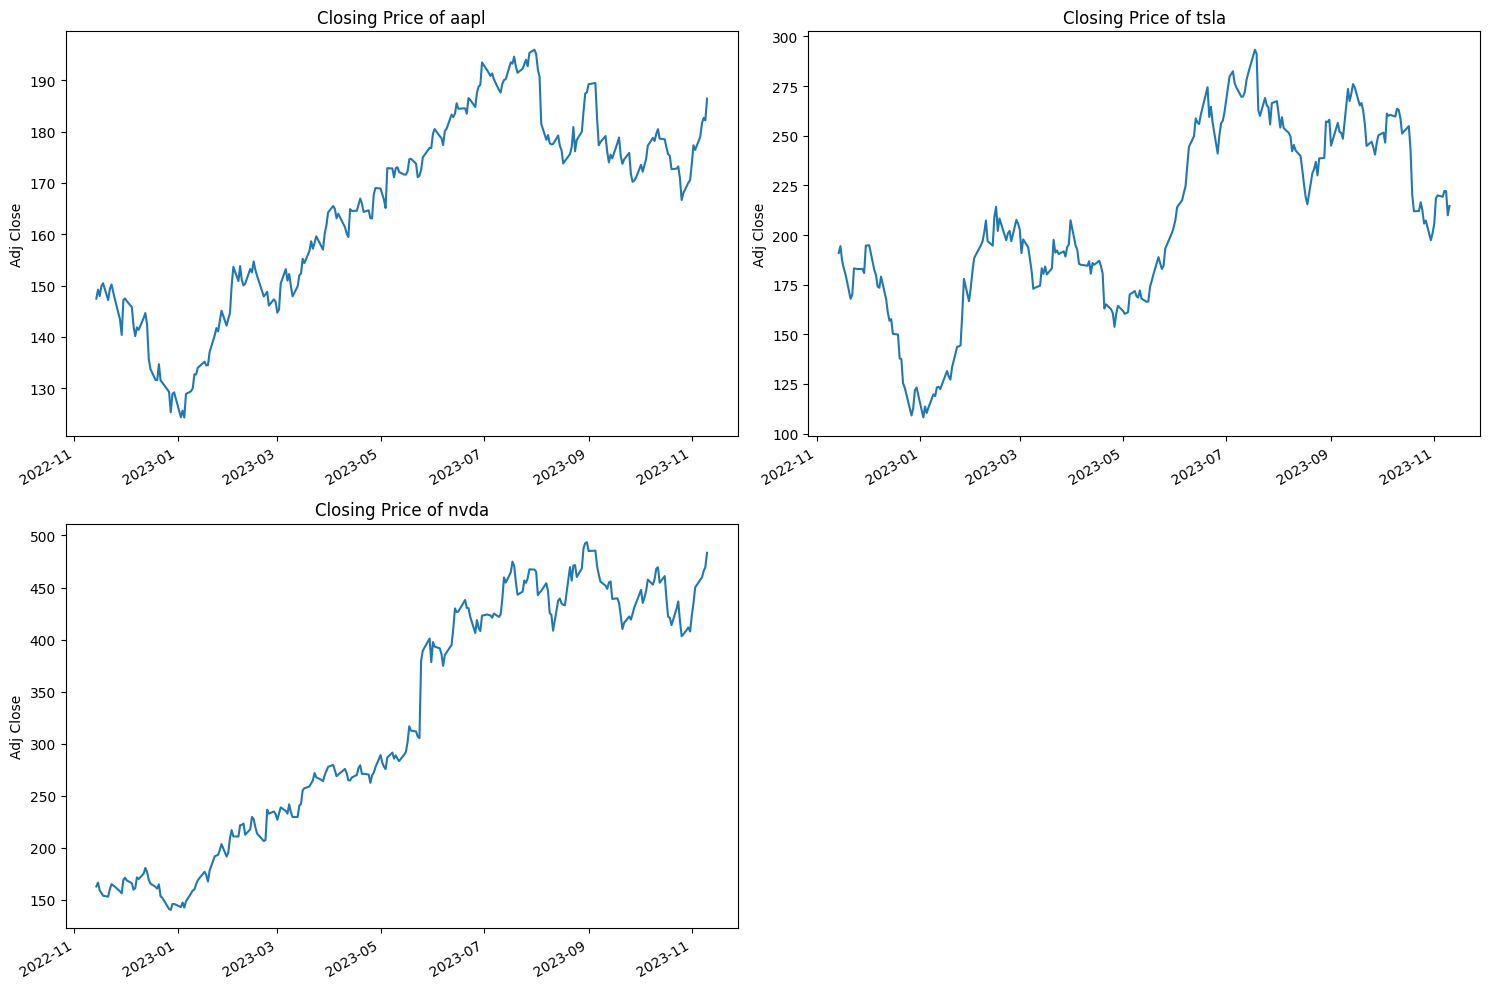

In [14]:
yf.pdr_override()

#Prepare data for easier visualization

tech_list = ["aapl", "tsla", "nvda"]

end = datetime.now()
start = datetime(end.year - 1, end.month, end.day)

for stock in tech_list:
    globals()[stock] = yf.download(stock, start, end)

company_list = [aapl, tsla, nvda]
company_name = ["aapl", "tsla", "nvda"]

for company, com_name in zip(company_list, company_name):
    company["company_name"] = com_name

df = pd.concat(company_list, axis=0)
# Let's see a historical view of the closing price
plt.figure(figsize=(15, 10))
plt.subplots_adjust(top=1.25, bottom=1.2)

for i, company in enumerate(company_list, 1):
    plt.subplot(2, 2, i)
    company['Adj Close'].plot()
    plt.ylabel('Adj Close')
    plt.xlabel(None)
    plt.title(f"Closing Price of {tech_list[i - 1]}")

plt.tight_layout()

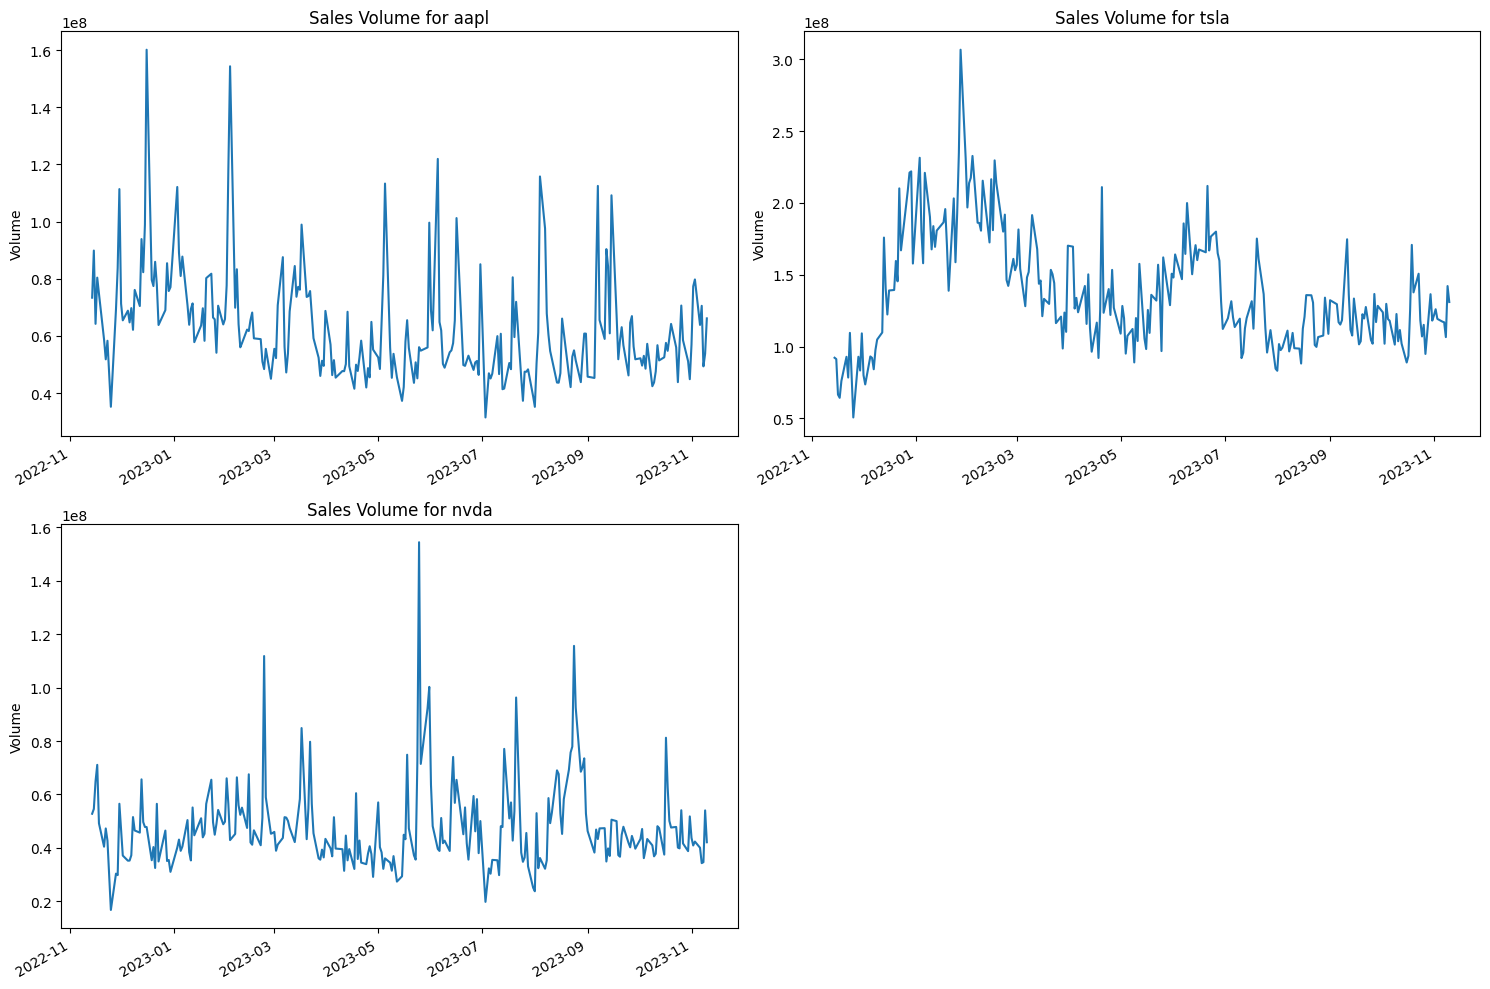

In [15]:

# Visualize the trading volume for each stock
plt.figure(figsize=(15, 10))
plt.subplots_adjust(top=1.25, bottom=1.2)

for i, company in enumerate(company_list, 1):
    plt.subplot(2, 2, i)
    company['Volume'].plot()
    plt.ylabel('Volume')
    plt.xlabel(None)
    plt.title(f"Sales Volume for {tech_list[i - 1]}")

plt.tight_layout()

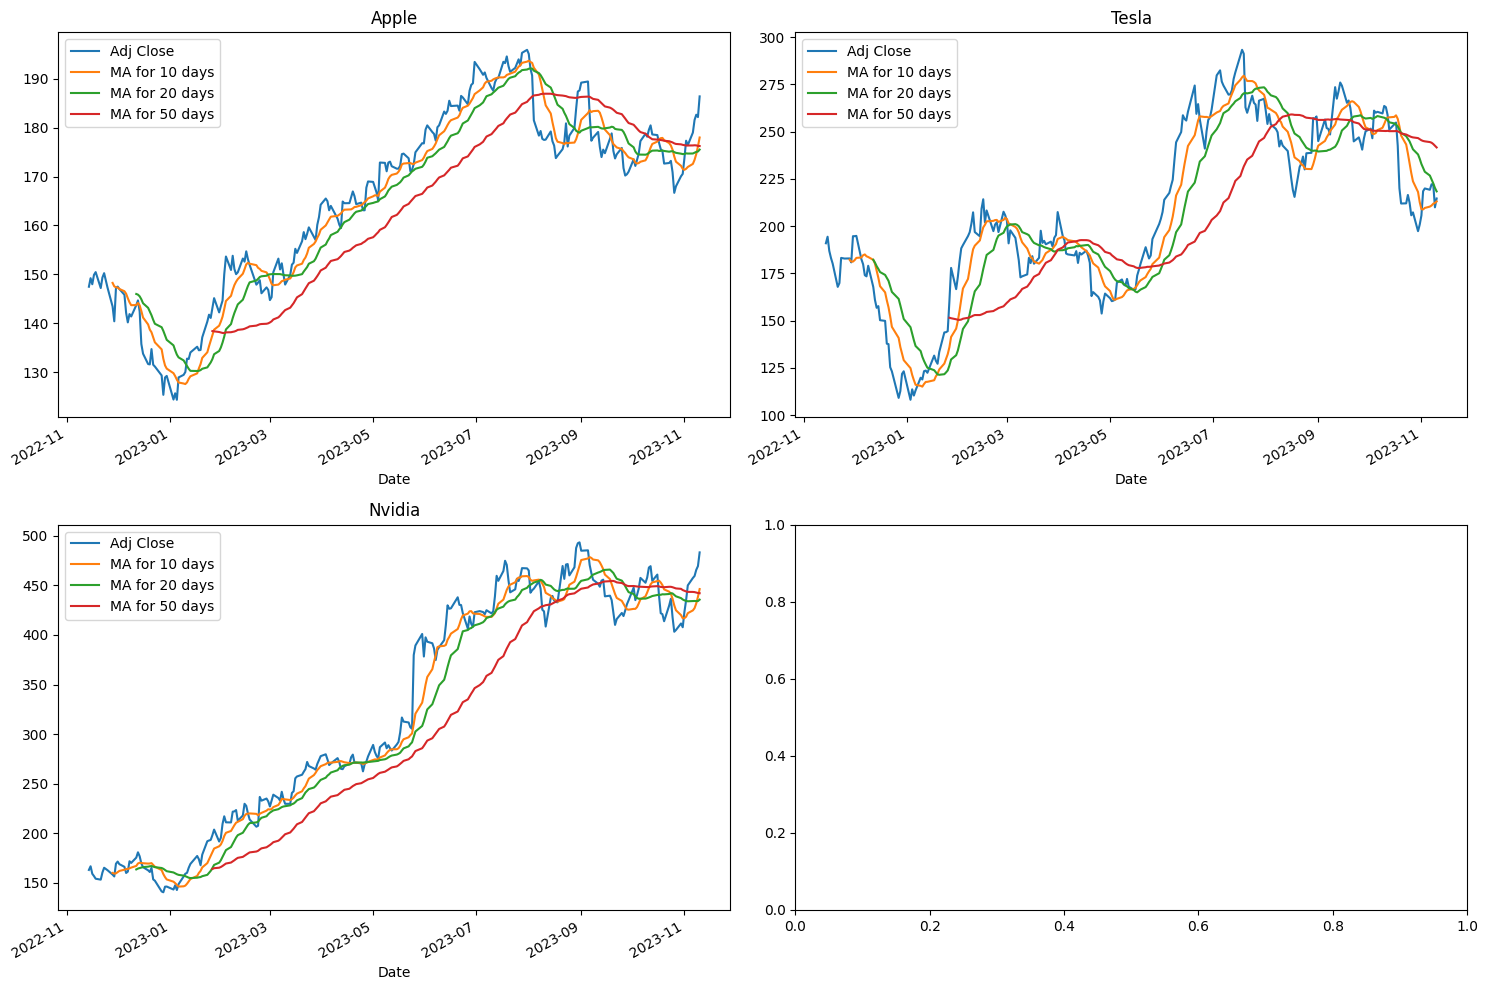

In [16]:
ma_day = [10, 20, 50]

for ma in ma_day:
    for company in company_list:
        column_name = f"MA for {ma} days"
        company[column_name] = company['Adj Close'].rolling(ma).mean()


fig, axes = plt.subplots(nrows=2, ncols=2)
fig.set_figheight(10)
fig.set_figwidth(15)

aapl[['Adj Close', 'MA for 10 days', 'MA for 20 days', 'MA for 50 days']].plot(ax=axes[0,0])
axes[0,0].set_title('Apple')

tsla[['Adj Close', 'MA for 10 days', 'MA for 20 days', 'MA for 50 days']].plot(ax=axes[0,1])
axes[0,1].set_title('Tesla')

nvda[['Adj Close', 'MA for 10 days', 'MA for 20 days', 'MA for 50 days']].plot(ax=axes[1,0])
axes[1,0].set_title('Nvidia')

fig.tight_layout()

In [17]:
# Grab all the closing prices for the tech stock list into one DataFrame

closing_df = pdr.get_data_yahoo(tech_list, start=start, end=end)['Adj Close']

# Make a new tech returns DataFrame
tech_rets = closing_df.pct_change()
tech_rets.head()

[*********************100%%**********************]  3 of 3 completed


,AAPL,NVDA,TSLA
Date,,,
2022-11-14,NaN,NaN,NaN
2022-11-15,0.011870,0.022768,0.018172
2022-11-16,-0.008331,-0.045362,-0.038576
2022-11-17,0.012971,-0.014645,-0.020062
2022-11-18,0.003782,-0.017095,-0.016269


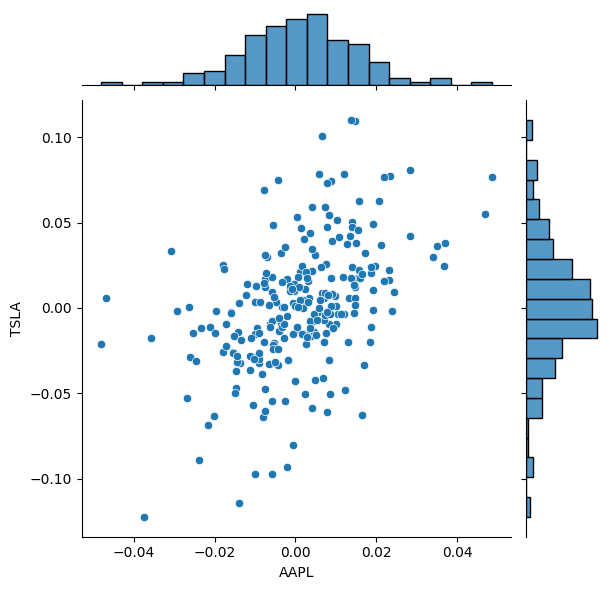

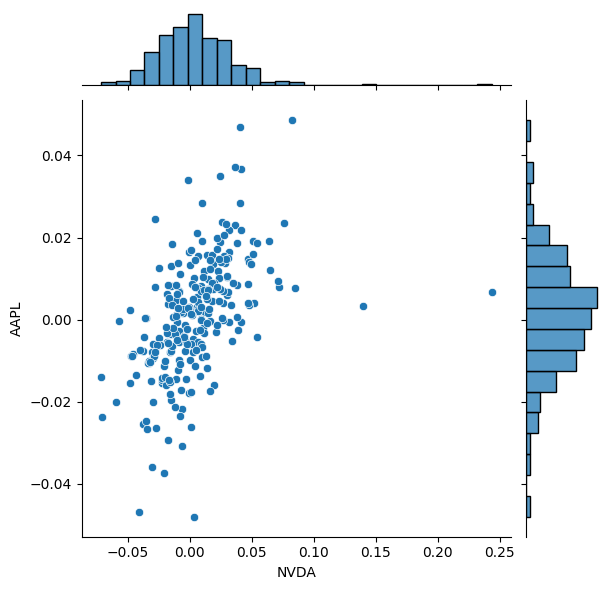

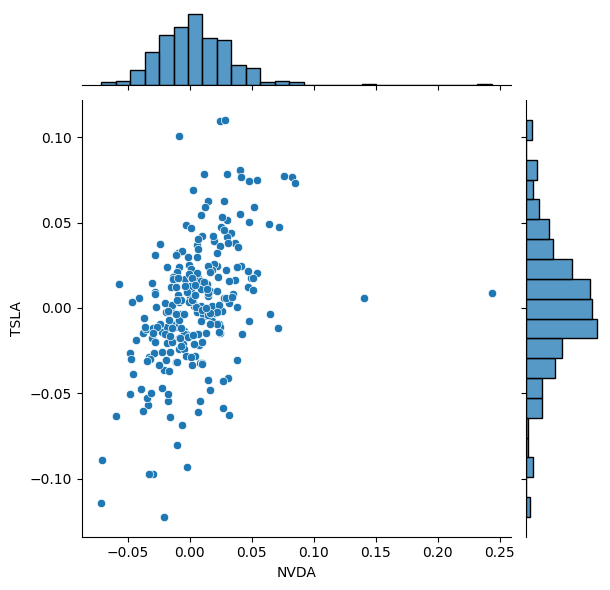

In [18]:
sns.jointplot(x='AAPL', y='TSLA', data=tech_rets, kind='scatter')
sns.jointplot(x='NVDA', y='AAPL', data=tech_rets, kind='scatter')
sns.jointplot(x='NVDA', y='TSLA', data=tech_rets, kind='scatter')



In [19]:
aapl_prices.tail(10)


,Open,High,Low,Close,Volume,Dividends,Stock Splits
Datetime,,,,,,,
2023-11-09 13:30:00-05:00,183.699997,183.729996,182.339996,182.820007,7012436,0.00,0.0
2023-11-09 14:30:00-05:00,182.820007,182.830002,181.809998,181.860001,5497017,0.00,0.0
2023-11-09 15:30:00-05:00,181.850006,182.479996,181.830002,182.440002,5102309,0.00,0.0
2023-11-10 09:30:00-05:00,183.770004,184.789993,183.529999,183.779907,13042014,0.24,0.0
2023-11-10 10:30:00-05:00,183.779999,184.940002,183.615005,184.750000,6727223,0.00,0.0
2023-11-10 11:30:00-05:00,184.759995,185.000000,184.429993,184.940002,4269310,0.00,0.0
2023-11-10 12:30:00-05:00,184.940094,185.509995,184.880005,185.404999,6479424,0.00,0.0
2023-11-10 13:30:00-05:00,185.404999,185.975006,185.399994,185.850006,5159113,0.00,0.0
2023-11-10 14:30:00-05:00,185.850006,186.130005,185.554993,186.119995,6857111,0.00,0.0


In [20]:
aapl_prices.count()

Open            3268
High            3268
Low             3268
Close           3268
Volume          3268
Dividends       3268
Stock Splits    3268
dtype: int64

In [21]:
aapl_prices.head()


,Open,High,Low,Close,Volume,Dividends,Stock Splits
Datetime,,,,,,,
2022-01-03 09:30:00-05:00,177.830002,181.429993,177.710007,180.839996,25170269,0.0,0.0
2022-01-03 10:30:00-05:00,180.850006,181.770004,180.389999,181.749893,11976542,0.0,0.0
2022-01-03 11:30:00-05:00,181.750000,181.770004,181.074997,181.600006,8143152,0.0,0.0
2022-01-03 12:30:00-05:00,181.595001,182.279007,181.490005,182.229706,8407914,0.0,0.0
2022-01-03 13:30:00-05:00,182.225006,182.880005,181.809998,181.865005,11618629,0.0,0.0


In [22]:
# Feature sclaing. Close price is used as the feature in time series
close_val = aapl_prices['Close'].values
close_val_t = np.reshape(close_val, (len(close_val),1))
scaler = MinMaxScaler(feature_range=(0, 1))
training_scaled = scaler.fit_transform(close_val_t)


In [23]:
x_train = []
y_train = []
for iter in range(60, 3000):
    x_train.append(training_scaled[iter-60:iter, 0])
    y_train.append(training_scaled[iter, 0])
x_train, y_train=np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
step_size = 1


In [24]:
jeff_LSTM = Sequential()
jeff_LSTM.add(LSTM(units = 50, return_sequences = True, input_shape = (x_train.shape[1], 1)))
jeff_LSTM.add(Dropout(0.2))
jeff_LSTM.add(LSTM(units = 50, return_sequences = True))
jeff_LSTM.add(Dropout(0.2))
jeff_LSTM.add(LSTM(units = 50, return_sequences = True))
jeff_LSTM.add(Dropout(0.2))
jeff_LSTM.add(LSTM(units = 50))
jeff_LSTM.add(Dropout(0.2))
jeff_LSTM.add(Dense(units = 1))


In [25]:

jeff_LSTM.compile(optimizer = 'adam', loss = 'mean_squared_error')
jeff_LSTM.fit(x_train, y_train, epochs = 100, batch_size = 32)



Epoch 1/100
92/92 [==============================] - 21s 137ms/step - loss: 0.0185
Epoch 2/100
92/92 [==============================] - 12s 135ms/step - loss: 0.0054
Epoch 3/100
92/92 [==============================] - 12s 131ms/step - loss: 0.0050
Epoch 4/100
92/92 [==============================] - 11s 119ms/step - loss: 0.0045
Epoch 5/100
92/92 [==============================] - 13s 137ms/step - loss: 0.0045
Epoch 6/100
92/92 [==============================] - 13s 138ms/step - loss: 0.0040
Epoch 7/100
92/92 [==============================] - 13s 136ms/step - loss: 0.0036
Epoch 8/100
92/92 [==============================] - 13s 138ms/step - loss: 0.0035
Epoch 9/100
92/92 [==============================] - 15s 159ms/step - loss: 0.0037
Epoch 10/100
92/92 [==============================] - 12s 125ms/step - loss: 0.0033
Epoch 11/100
92/92 [==============================] - 12s 125ms/step - loss: 0.0029
Epoch 12/100
92/92 [==============================] - 13s 137ms/step - loss: 0.0029
E

In [84]:
data_train = aapl_prices.iloc[:3000, 3]
data_test = aapl_prices.iloc[:, 3]
data_total = pd.concat((data_train, data_test), axis = 0)
total_input = data_total[len(data_total) - len(data_test) - 1:].values
total_input = total_input.reshape(-1,1)
total_input = scaler.transform(total_input)
x_test = []
for iter in range(3000, len(data_test)):
    x_test.append(total_input[iter-60:iter, 0])
x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
print(x_test.shape)

predicted_price = jeff_LSTM.predict(x_test)
predicted_price = scaler.inverse_transform(predicted_price)

(268, 60, 1)
9/9 [==============================] - 0s 44ms/step


In [85]:
#Reformat the data for MSE calculation
date_index = aapl_prices.index[3000:len(data_test)]
predicted_price = pd.DataFrame(predicted_price)
predicted_price.set_index(date_index, inplace=True)

In [86]:
from sklearn.metrics import mean_squared_error

#Define MSE generation function to generate MSE for hourly predicted MSE on given date
def calculate_hourly_mse(date, predicted_prices, actual_prices):
    # Filter the predicted and actual prices for the specified date
    predicted_prices_date = predicted_prices.loc[date]
    actual_prices_date = actual_prices.loc[date]

    # Calculate the MSE for each hour and print the results
    for hour in predicted_prices_date.index:
        try:
            mse = mean_squared_error([actual_prices_date.loc[hour]], [predicted_prices_date.loc[hour]])
            print(f"Date: {date}, Hour: {hour}, MSE: {mse}")
        except KeyError:
            print(f"No data available for hour: {hour}")

In [87]:
#We take a previous date to calculate the MSE to examine the perfomance of our model
date = "2023-11-09"
expected_value = data_test[3000:len(data_test)]
hourly_mse = calculate_hourly_mse(date, predicted_price, expected_value)
print(hourly_mse)

Date: 2023-11-09, Hour: 2023-11-09 09:30:00-05:00, MSE: 1.3121182331815362
Date: 2023-11-09, Hour: 2023-11-09 10:30:00-05:00, MSE: 3.7963611222803593
Date: 2023-11-09, Hour: 2023-11-09 11:30:00-05:00, MSE: 4.4952851021662354
Date: 2023-11-09, Hour: 2023-11-09 12:30:00-05:00, MSE: 2.7945027744863182
Date: 2023-11-09, Hour: 2023-11-09 13:30:00-05:00, MSE: 0.3695733102504164
Date: 2023-11-09, Hour: 2023-11-09 14:30:00-05:00, MSE: 0.2211594022810459
Date: 2023-11-09, Hour: 2023-11-09 15:30:00-05:00, MSE: 0.4097359487786889
None


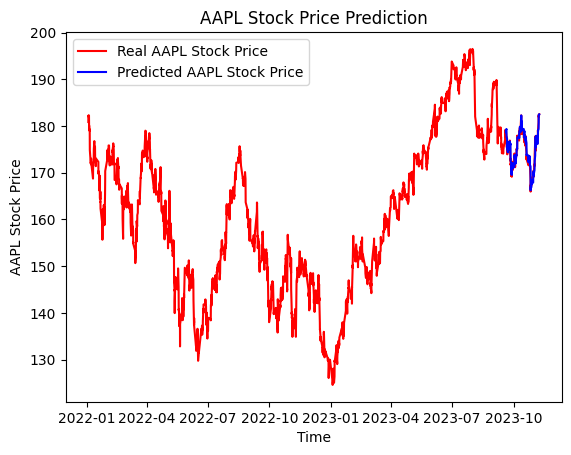

In [ ]:
plt.plot(data_test, color = 'red', label = 'Real AAPL Stock Price')
plt.plot(predicted_price, color = 'blue', label = 'Predicted AAPL Stock Price')
plt.title('AAPL Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('AAPL Stock Price')
plt.legend()
plt.show()


In [88]:
#In the model, we use 60 timesteps to make prediction for Nov 13th
last_60_hours = aapl_prices['Close'][-60:].values

time_labels = ["9:30", "10:30", "11:30","12:30","13:30","14:30","15:30"]

for i in range(7):
    last_60_hours_scaled = scaler.transform(last_60_hours.reshape(-1, 1))
    last_60_hours_scaled = np.reshape(last_60_hours_scaled, (1, 60, 1))
    predicted_price_AAPL = jeff_LSTM.predict(last_60_hours_scaled)

    predicted_price_AAPL = scaler.inverse_transform(predicted_price_AAPL)

    current_time_label = time_labels[i]

    print(f"AAPL Predicted stock price for {current_time_label}: {predicted_price_AAPL}")

    last_60_hours = np.append(last_60_hours[1:], predicted_price_AAPL)

1/1 [==============================] - 0s 154ms/step
AAPL Predicted stock price for 9:30: [[184.85214]]
1/1 [==============================] - 0s 155ms/step
AAPL Predicted stock price for 10:30: [[183.94536]]
1/1 [==============================] - 0s 109ms/step
AAPL Predicted stock price for 11:30: [[183.09358]]
1/1 [==============================] - 0s 146ms/step
AAPL Predicted stock price for 12:30: [[182.33047]]
1/1 [==============================] - 0s 91ms/step
AAPL Predicted stock price for 13:30: [[181.56425]]
1/1 [==============================] - 0s 60ms/step
AAPL Predicted stock price for 14:30: [[180.8029]]
1/1 [==============================] - 0s 118ms/step
AAPL Predicted stock price for 15:30: [[180.0465]]


In [89]:
# Feature Scaling
close_val_tsla = tsla_prices['Close'].values
# PREPARATION OF TIME SERIES DATASE
close_val_tsla = np.reshape(close_val_tsla, (len(close_val_tsla),1))
scaler = MinMaxScaler(feature_range=(0, 1))
training_scaled = scaler.fit_transform(close_val_tsla)

In [90]:
x_train = []
y_train = []
for iter in range(60, 3000):
    x_train.append(training_scaled[iter-60:iter, 0])
    y_train.append(training_scaled[iter, 0])
x_train, y_train=np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
step_size = 1


In [92]:
jeff_LSTM.compile(optimizer = 'adam', loss = 'mean_squared_error')
jeff_LSTM.fit(x_train, y_train, epochs = 100, batch_size = 32)


Epoch 1/100
92/92 [==============================] - 27s 140ms/step - loss: 7.5502e-04
Epoch 2/100
92/92 [==============================] - 18s 197ms/step - loss: 6.1025e-04
Epoch 3/100
92/92 [==============================] - 24s 266ms/step - loss: 5.9310e-04
Epoch 4/100
92/92 [==============================] - 16s 178ms/step - loss: 5.2918e-04
Epoch 5/100
92/92 [==============================] - 13s 145ms/step - loss: 5.8721e-04
Epoch 6/100
92/92 [==============================] - 18s 199ms/step - loss: 5.4014e-04
Epoch 7/100
92/92 [==============================] - 13s 140ms/step - loss: 5.9584e-04
Epoch 8/100
92/92 [==============================] - 13s 139ms/step - loss: 5.4791e-04
Epoch 9/100
92/92 [==============================] - 12s 126ms/step - loss: 5.3655e-04
Epoch 10/100
92/92 [==============================] - 13s 142ms/step - loss: 5.0405e-04
Epoch 11/100
92/92 [==============================] - 13s 142ms/step - loss: 5.4124e-04
Epoch 12/100
92/92 [=====================

In [93]:
data_train = tsla_prices.iloc[:3000, 3]
data_test = tsla_prices.iloc[:, 3]
data_total = pd.concat((data_train, data_test), axis = 0)
total_input = data_total[len(data_total) - len(data_test) - 1:].values
total_input = total_input.reshape(-1,1)
total_input = scaler.transform(total_input)
x_test = []
for iter in range(3000, len(data_test)):
    x_test.append(total_input[iter-60:iter, 0])
x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
print(x_test.shape)

predicted_price = jeff_LSTM.predict(x_test)
predicted_price = scaler.inverse_transform(predicted_price)

(268, 60, 1)
9/9 [==============================] - 2s 34ms/step


In [94]:
date_index = nvda_prices.index[3000:len(data_test)]
predicted_price = pd.DataFrame(predicted_price)
predicted_price.set_index(date_index, inplace=True)

In [95]:
# Assuming you have predicted values in `predictions` and actual values in `actual`
date = "2023-11-09"
expected_value = data_test[3000:len(data_test)]
hourly_mse = calculate_hourly_mse(date, predicted_price, expected_value)
print(hourly_mse)

Date: 2023-11-09, Hour: 2023-11-09 09:30:00-05:00, MSE: 75.17442468646914
Date: 2023-11-09, Hour: 2023-11-09 10:30:00-05:00, MSE: 91.76561813894659
Date: 2023-11-09, Hour: 2023-11-09 11:30:00-05:00, MSE: 33.563437167555094
Date: 2023-11-09, Hour: 2023-11-09 12:30:00-05:00, MSE: 22.20702347252518
Date: 2023-11-09, Hour: 2023-11-09 13:30:00-05:00, MSE: 1.677494533592835
Date: 2023-11-09, Hour: 2023-11-09 14:30:00-05:00, MSE: 2.150463644647971
Date: 2023-11-09, Hour: 2023-11-09 15:30:00-05:00, MSE: 0.09874646458774805
None


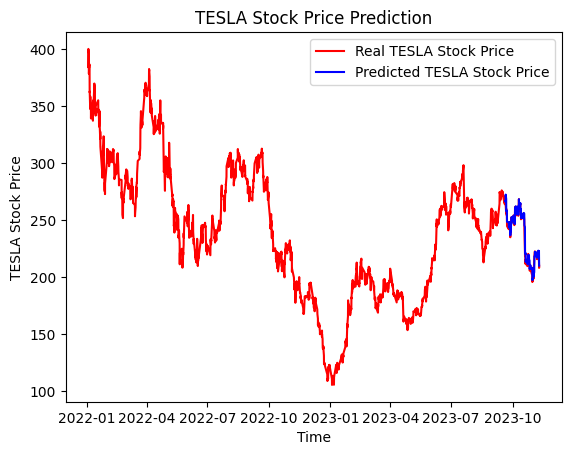

In [ ]:
plt.plot(data_test, color = 'red', label = 'Real TESLA Stock Price')
plt.plot(predicted_price, color = 'blue', label = 'Predicted TESLA Stock Price')
plt.title('TESLA Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('TESLA Stock Price')
plt.legend()
plt.show()


In [102]:
#In the model, we use 60 timesteps to make prediction for Nov 13th
last_60_hours = tsla_prices['Close'][-60:].values

time_labels = ["9:30", "10:30", "11:30","12:30","13:30","14:30","15:30"]

for i in range(7):
    last_60_hours_scaled = scaler.transform(last_60_hours.reshape(-1, 1))
    last_60_hours_scaled = np.reshape(last_60_hours_scaled, (1, 60, 1))
    predicted_price_TSLA = jeff_LSTM.predict(last_60_hours_scaled)

    predicted_price_TSLA = scaler.inverse_transform(predicted_price_TSLA)

    current_time_label = time_labels[i]

    print(f"TSLA Predicted stock price for {current_time_label}: {predicted_price_TSLA}")

    last_60_hours = np.append(last_60_hours[1:], predicted_price_TSLA)

1/1 [==============================] - 0s 38ms/step
TSLA Predicted stock price for 9:30: [[200.71652]]
1/1 [==============================] - 0s 31ms/step
TSLA Predicted stock price for 10:30: [[201.45338]]
1/1 [==============================] - 0s 38ms/step
TSLA Predicted stock price for 11:30: [[199.49872]]
1/1 [==============================] - 0s 31ms/step
TSLA Predicted stock price for 12:30: [[198.60796]]
1/1 [==============================] - 0s 34ms/step
TSLA Predicted stock price for 13:30: [[197.49554]]
1/1 [==============================] - 0s 32ms/step
TSLA Predicted stock price for 14:30: [[196.39839]]
1/1 [==============================] - 0s 41ms/step
TSLA Predicted stock price for 15:30: [[195.37633]]


In [110]:
# Feature Scaling
close_val_nvda = nvda_prices['Close'].values
# PREPARATION OF TIME SERIES DATASE
close_val_nvda = np.reshape(close_val, (len(close_val),1))
scaler = MinMaxScaler(feature_range=(0, 1))
training_scaled = scaler.fit_transform(close_val_nvda)

In [111]:
x_train = []
y_train = []
for iter in range(60, 3000):
    x_train.append(training_scaled[iter-60:iter, 0])
    y_train.append(training_scaled[iter, 0])
x_train, y_train=np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
step_size = 1


In [112]:
jeff_LSTM_nvda = Sequential()
jeff_LSTM_nvda.add(LSTM(units = 50, return_sequences = True, input_shape = (x_train.shape[1], 1)))
jeff_LSTM_nvda.add(Dropout(0.2))
jeff_LSTM_nvda.add(LSTM(units = 50, return_sequences = True))
jeff_LSTM_nvda.add(Dropout(0.2))
jeff_LSTM_nvda.add(LSTM(units = 50, return_sequences = True))
jeff_LSTM_nvda.add(Dropout(0.2))
jeff_LSTM_nvda.add(LSTM(units = 50))
jeff_LSTM_nvda.add(Dropout(0.2))
jeff_LSTM_nvda.add(Dense(units = 1))


In [113]:
jeff_LSTM_nvda.compile(optimizer = 'adam', loss = 'mean_squared_error')
jeff_LSTM_nvda.fit(x_train, y_train, epochs = 10, batch_size = 100)


Epoch 1/10
30/30 [==============================] - 44s 211ms/step - loss: 0.0403
Epoch 2/10
30/30 [==============================] - 7s 232ms/step - loss: 0.0068
Epoch 3/10
30/30 [==============================] - 13s 421ms/step - loss: 0.0056
Epoch 4/10
30/30 [==============================] - 8s 265ms/step - loss: 0.0054
Epoch 5/10
30/30 [==============================] - 6s 203ms/step - loss: 0.0052
Epoch 6/10
30/30 [==============================] - 8s 270ms/step - loss: 0.0049
Epoch 7/10
30/30 [==============================] - 6s 205ms/step - loss: 0.0049
Epoch 8/10
30/30 [==============================] - 10s 330ms/step - loss: 0.0045
Epoch 9/10
30/30 [==============================] - 7s 214ms/step - loss: 0.0046
Epoch 10/10
30/30 [==============================] - 8s 267ms/step - loss: 0.0044


In [114]:
data_train = nvda_prices.iloc[:3000, 3]
data_test = nvda_prices.iloc[:, 3]
data_total = pd.concat((data_train, data_test), axis = 0)
total_input = data_total[len(data_total) - len(data_test) - 1:].values
total_input = total_input.reshape(-1,1)
total_input = scaler.transform(total_input)
x_test = []
for iter in range(3000, len(data_test)):
    x_test.append(total_input[iter-60:iter, 0])
x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
print(x_test.shape)

predicted_price = jeff_LSTM.predict(x_test)
predicted_price = scaler.inverse_transform(predicted_price)

(268, 60, 1)
9/9 [==============================] - 0s 51ms/step


In [115]:
date_index = nvda_prices.index[3000:len(data_test)]
predicted_price = pd.DataFrame(predicted_price)
predicted_price.set_index(date_index, inplace=True)

In [122]:
# Assuming you have predicted values in `predictions` and actual values in `actual`
evaluation_date = "2023-11-09"
expected_value = data_test[3000:len(data_test)]
hourly_mse = calculate_hourly_mse(evaluation_date, predicted_price, expected_value)

Date: 2023-11-09, Hour: 2023-11-09 09:30:00-05:00, MSE: 83729.15696983249
Date: 2023-11-09, Hour: 2023-11-09 10:30:00-05:00, MSE: 85065.48653014097
Date: 2023-11-09, Hour: 2023-11-09 11:30:00-05:00, MSE: 85396.05169920833
Date: 2023-11-09, Hour: 2023-11-09 12:30:00-05:00, MSE: 85760.4557956683
Date: 2023-11-09, Hour: 2023-11-09 13:30:00-05:00, MSE: 82414.98877823446
Date: 2023-11-09, Hour: 2023-11-09 14:30:00-05:00, MSE: 80345.14640465588
Date: 2023-11-09, Hour: 2023-11-09 15:30:00-05:00, MSE: 80162.08123925701


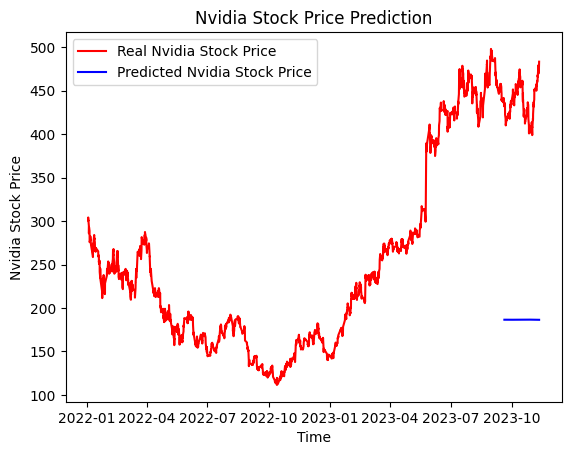

In [117]:
plt.plot(data_test, color = 'red', label = 'Real Nvidia Stock Price')
plt.plot(predicted_price, color = 'blue', label = 'Predicted Nvidia Stock Price')
plt.title('Nvidia Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Nvidia Stock Price')
plt.legend()
plt.show()

In [119]:
#In the model, we use 60 timesteps to make prediction for Nov 13th
last_60_hours = tsla_prices['Close'][-60:].values

time_labels = ["9:30", "10:30", "11:30","12:30","13:30","14:30","15:30"]

for i in range(7):
    last_60_hours_scaled = scaler.transform(last_60_hours.reshape(-1, 1))
    last_60_hours_scaled = np.reshape(last_60_hours_scaled, (1, 60, 1))
    predicted_price_NVDA = jeff_LSTM.predict(last_60_hours_scaled)

    predicted_price_NVDA = scaler.inverse_transform(predicted_price_NVDA)

    current_time_label = time_labels[i]

    print(f"TSLA Predicted stock price for {current_time_label}: {predicted_price_NVDA}")

    last_60_hours = np.append(last_60_hours[1:], predicted_price_NVDA)

1/1 [==============================] - 0s 158ms/step
TSLA Predicted stock price for 9:30: [[200.71652]]
1/1 [==============================] - 0s 95ms/step
TSLA Predicted stock price for 10:30: [[201.45338]]
1/1 [==============================] - 0s 116ms/step
TSLA Predicted stock price for 11:30: [[199.49872]]
1/1 [==============================] - 0s 111ms/step
TSLA Predicted stock price for 12:30: [[198.60796]]
1/1 [==============================] - 0s 119ms/step
TSLA Predicted stock price for 13:30: [[197.49554]]
1/1 [==============================] - 0s 117ms/step
TSLA Predicted stock price for 14:30: [[196.39839]]
1/1 [==============================] - 0s 140ms/step
TSLA Predicted stock price for 15:30: [[195.37633]]


In [133]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import pandas as pd

models = {}
idx = pd.IndexSlice
X = nvda_prices.loc[:, idx['Open', 'High', 'Low', 'Volume']]
y = nvda_prices.loc[:, 'Close']

# Splitting the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0,shuffle=False)

# Fitting the model
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)

# Making predictions
predictions = linear_model.predict(X_test)

# Calculating the mean squared error
mse = mean_squared_error(y_test, predictions)

print(mse)

2.09939441402364


In [136]:
import warnings
warnings.filterwarnings("ignore", message="")

# Create a DataFrame to store the predicted prices for November 13th
predicted_prices = pd.DataFrame(index=pd.date_range(start='2023-11-13 09:30:00', end='2023-11-13 15:30:00', freq='H'))

# Use the trained linear model to make predictions for each hourly interval on November 13th
for dt in predicted_prices.index:
    input_data = nvda_prices.loc[dt - pd.DateOffset(days=3), ['Open', 'High', 'Low', 'Volume']].values.reshape(1, -1)
    predicted_price = linear_model.predict(input_data)
    predicted_prices.loc[dt, 'PredictedPrice'] = predicted_price[0]

# Print the predicted prices for November 13th
print(predicted_prices)

                     PredictedPrice
2023-11-13 09:30:00      476.950473
2023-11-13 10:30:00      478.593201
2023-11-13 11:30:00      479.015692
2023-11-13 12:30:00      481.489857
2023-11-13 13:30:00      482.942107
2023-11-13 14:30:00      483.799346
2023-11-13 15:30:00      483.158705


In [ ]:
def predict_and_evaluate(model, date, data):
    try:
        # Ensure data is present for live operations
        if data.empty:
            print(f"No data available on {date}")
            return None

        # Preprocess data to match model input format
        data['Hour'] = data.index.hour
        hourly_mse = {}

        # Adjusted market hours (9:30 AM to 3:00 PM)
        for hour in range(9, 16):  # Loop over market hours
            hourly_data = data.between_time(f'{hour}:00', f'{hour}:59')  # Fetch minute data for the specific hour
            if not hourly_data.empty:
                features = hourly_data[['Open', 'High', 'Low', 'Volume']]
                true_values = hourly_data['Close']
                predictions = model.predict(features)
                mse = mean_squared_error(true_values, predictions)
                hourly_mse[hour] = mse
            else:
                hourly_mse[hour] = np.nan  # Use NaN for hours without data

        return hourly_mse
    except Exception as e:
        print(f"An error occurred: {e}")
        return None

In [ ]:
evaluation_date = '2023-11-6'
hourly_mse = predict_and_evaluate(linear_model, evaluation_date,nvda_prices)
if hourly_mse is not None:
    for hour, mse in hourly_mse.items():
        print(f'The MSE for prediction on the date of {evaluation_date} Hour: {hour}, MSE: {mse}')
else:
    print(f"Unable to evaluate for the date: {evaluation_date}")

The MSE for prediction on the date of 2023-11-6 Hour: 9, MSE: 4.118145327944498
The MSE for prediction on the date of 2023-11-6 Hour: 10, MSE: 1.175698814551721
The MSE for prediction on the date of 2023-11-6 Hour: 11, MSE: 0.8292187829539434
The MSE for prediction on the date of 2023-11-6 Hour: 12, MSE: 0.7127599147279085
The MSE for prediction on the date of 2023-11-6 Hour: 13, MSE: 0.6770940937448966
The MSE for prediction on the date of 2023-11-6 Hour: 14, MSE: 0.8633705923496042
The MSE for prediction on the date of 2023-11-6 Hour: 15, MSE: 0.501084892487097


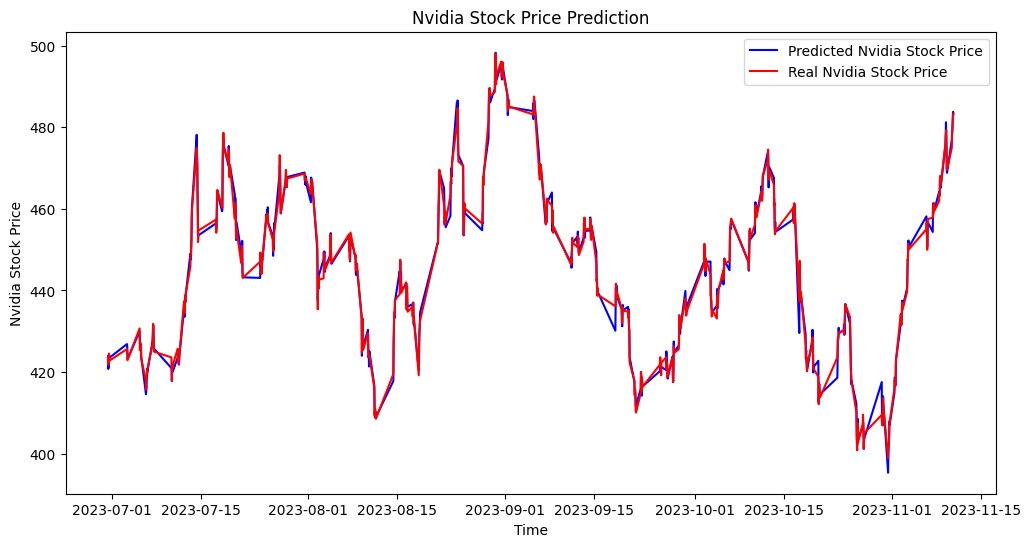

In [132]:
# Create a range of x values from 0 to the length of y_test
x = y_test.index

plt.figure(figsize=(12,6))

# Plot the predicted values
plt.plot(x, predictions, label='Predicted Nvidia Stock Price', color='blue')

# Plot the true values
plt.plot(x, y_test, label='Real Nvidia Stock Price', color='red')

# Add a legend
plt.legend()

# Add title and labels
plt.title('Nvidia Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Nvidia Stock Price')

# Show the plot
plt.show()
